EDGE DETECTION AND WARPING:
----

Goals:
- to detect the corners of the input image 
- crop the image out with the new corners detected - warping


Python modules utilized:
- `numpy`, `matplotlib`, `cv2`, `PIL`,and all built-in python libraries (e.g. `math` and `string`) 

Instructions:
- input the image path in 'img_path' 
- Double check that you have completed Task 0.
- Submit your work on Gradescope.

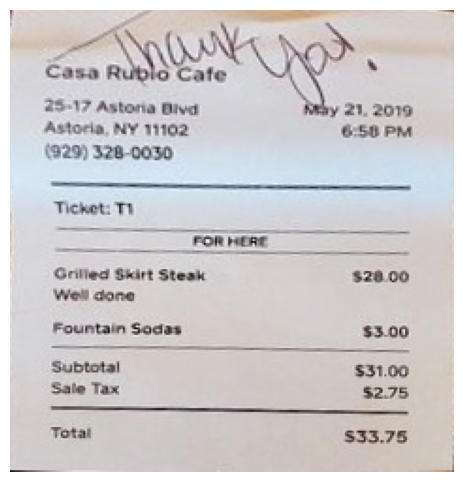

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = 'large-receipt-image-dataset-SRD/1167-receipt.jpg'
image = cv2.imread(image_path)

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Use the Canny algorithm to detect edges
edges = cv2.Canny(gray, 50, 150, apertureSize=3)

# Find contours from the edges, keeping only the largest ones
contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

# Assume the largest contour is the receipt
receipt_contour = None
for c in contours:
    # Approximate the contour
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)

    # The receipt should have four corners
    if len(approx) == 4:
        receipt_contour = approx
        break

# If a receipt contour was not detected, raise an error
if receipt_contour is None:
    raise ValueError("Could not find receipt contour. Make sure the receipt is clear in the image.")

# Compute the bounding box of the receipt and perform the perspective transform
def order_points(pts):
    # initialzie a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    rect = np.zeros((4, 2), dtype="float32")
 
    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
 
    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
 
    # return the ordered coordinates
    return rect

def four_point_transform(image, pts):
    # obtain a consistent order of the points and unpack them
    # individually
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
 
    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
 
    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
 
    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
 
    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
 
    # return the warped image
    return warped

# Get the points of the receipt contour in the correct order
receipt_points = receipt_contour.reshape(4, 2)

# Perform the four point transform to obtain a top-down view of the receipt
# Perform the four point transform to obtain a top-down view of the receipt
warped = four_point_transform(image, receipt_points.astype("float32"))

# Convert the warped image to a byte array for output
_, im_buf_arr = cv2.imencode('.jpg', warped)
warped_bytes = im_buf_arr.tobytes()

# Write the warped image to a file to check the result
output_path = 'warped_receipt.jpg'
with open(output_path, 'wb') as f_out:
    f_out.write(warped_bytes)

warped_image = cv2.imread(output_path)

# Convert from BGR to RGB color space for plotting
warped_image_rgb = cv2.cvtColor(warped_image, cv2.COLOR_BGR2RGB)

# Display the image using matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(warped_image_rgb)
plt.axis('off')  # Hide the axis
plt.show()


In [2]:
#Trying a different approach
import base64
import io
import os
from pprint import pprint
from functions import *

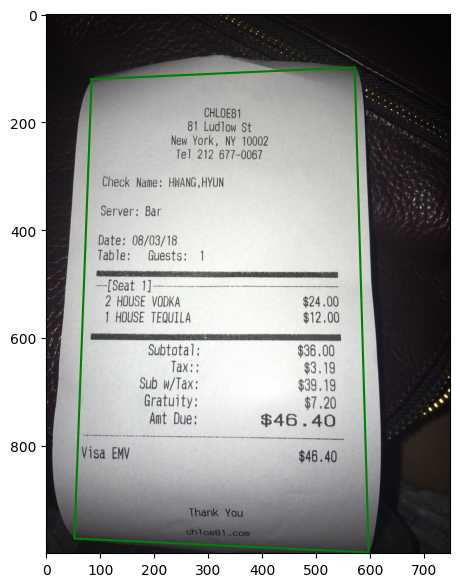

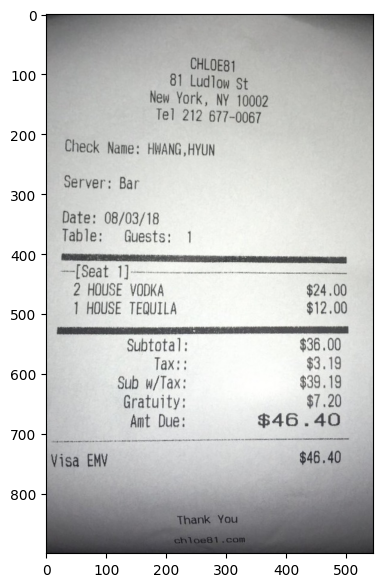

In [3]:
TOKEN = 'github_users'
auth_header = {'Content-Type' : 'application/json',
               'Authorization': f'{TOKEN}'}
BASE_URL_PARSER = 'https://tinvois-parser.azurewebsites.net/'

img_path = 'large-receipt-image-dataset-SRD/1144-receipt.jpg'

res_edges = perform_query(BASE_URL_PARSER, 'detect_edges', 'GET', headers=auth_header, 
                    data={'image': get_image_content(img_path)})
ax = show_image(img_path)
show_edges(ax, res_edges['data'])

res_bird_view = perform_query(BASE_URL_PARSER, 'bird_view', 'POST', headers=auth_header, 
                    data={'image': get_image_content(img_path), 'points': res_edges['data']})

image_bytes = base64.b64decode(res_bird_view['data'])
_ = show_image(io.BytesIO(image_bytes))

OPTICAL CHARACTER RECOGNITION:
----

Goals:
- to extract usefull text from the given image 
- use of Regex to get desired text


Python modules utilized:
- `numpy`, `matplotlib`, `cv2`, `PIL`, `re`, `paddleocr`, and all built-in python libraries (e.g. `math` and `string`) 

Instructions:
- input the warped image path in 'img_path' 

1. RECEIPTS:
---

Idea:
- to extract usefull text from the recepit - date and total amount 
- use of Regex to find all dates of the format - dd/mm/yyy or mm/dd/yyy 
- use of Regex to find all prices listed in the format $ or £ or € followed by a number

[2024/04/24 17:01:55] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/Users/sanjanajd/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/Users/sanjanajd/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25

[2024/04/24 17:01:57] ppocr DEBUG: dt_boxes num : 28, elapsed : 0.39450597763061523
[2024/04/24 17:01:57] ppocr DEBUG: cls num  : 28, elapsed : 0.2339305877685547
[2024/04/24 17:02:01] ppocr DEBUG: rec_res num  : 28, elapsed : 3.7181248664855957
Total price: 46.4
Dates found: ['08/03/18']


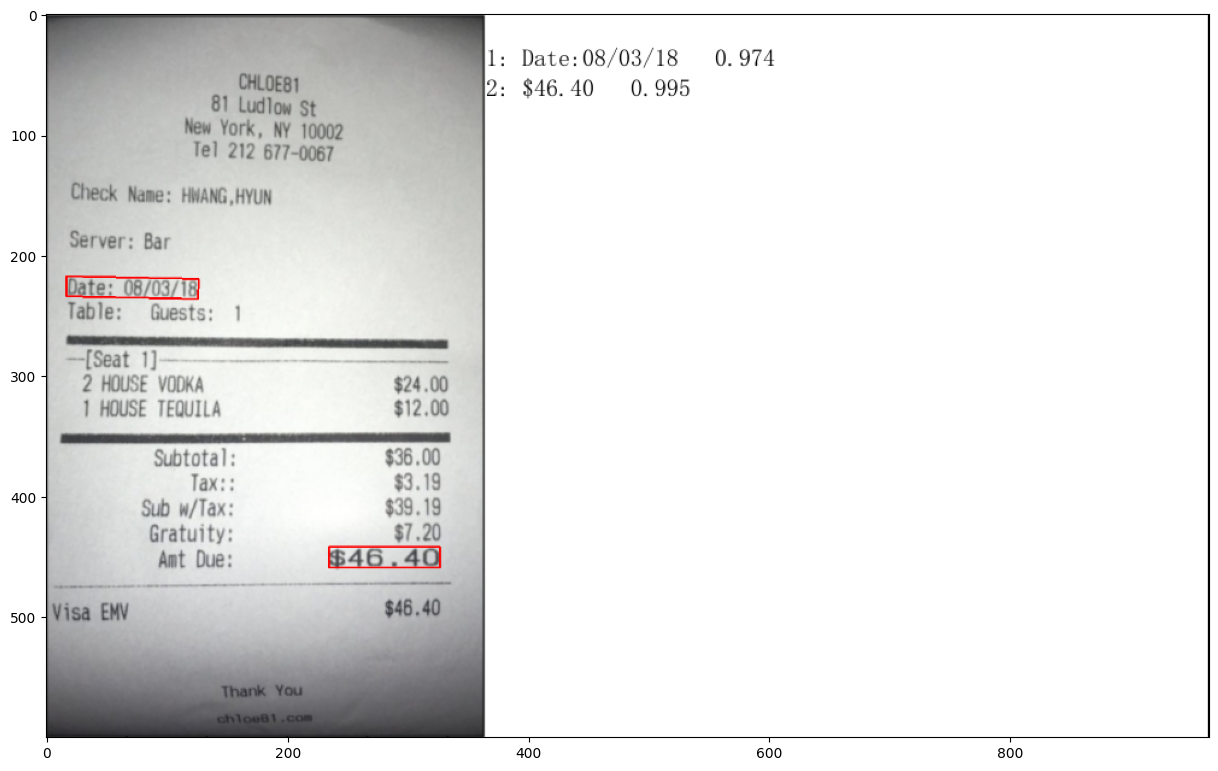

In [6]:
from paddleocr import PaddleOCR, draw_ocr
import cv2
import matplotlib.pyplot as plt
import re
from PIL import Image, ImageDraw, ImageFont

# Set the display size for matplotlib figures.
plt.rcParams['figure.figsize'] = [15, 10]

# Initialize the OCR model.
ocr = PaddleOCR(use_angle_cls=True, lang='en')

# Path to the image file.
img_path = 'warped2.png'
image = Image.open(img_path).convert('RGB')
img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)

# Perform OCR on the image.
results = ocr.ocr(img_path, cls=True)[0]

# Initialize variables to store the maximum price and dates.
max_price = 0
max_price_text = ""
dates = []
pp =[]

# Initialize lists to store boxes and texts for drawing.
draw_boxes = []
draw_texts = []
draw_scores = []

# Iterate through each line of OCR results.
for line in results:
    text = line[1][0]  # Extracting the text string from the result.
    if text != "CASH":
        # Find amounts and dates in the text.
        amount_strings = re.findall(r'[\$\£\€](\d+(?:\.\d{1,2})?)', text)
        prices = list(map(float, amount_strings))
        if prices:
            current_max = max(prices)
            if current_max > max_price:
                max_price = current_max  # Update max_price if the current max is greater.
                max_price_text = text  # Store text of the max price for drawing.
                pp.append(max_price)


        date_matches = re.findall(r'\d+[/.-]\d+[/.-]\d+', text)
        if date_matches:
            dates.extend(date_matches)  # Append found dates to the list.
            draw_boxes.append(line[0])  # Store box for drawing.
            draw_texts.append(text)
            draw_scores.append(line[1][1])
    else:
        break

# Check and add the max price box to draw, if not already included.
if max_price_text and not any(max_price_text in text for text in draw_texts):
    max_price_line = next((line for line in results if line[1][0] == max_price_text), None)
    if max_price_line:
        draw_boxes.append(max_price_line[0])
        draw_texts.append(max_price_line[1][0])
        draw_scores.append(max_price_line[1][1])

# Print the results.
print(f"Total price: {max_price}")
print(f"Dates found: {dates}")

# Drawing results on the image.
im_show = draw_ocr(image, draw_boxes, draw_texts, draw_scores, font_path='simfang.ttf')
im_show = Image.fromarray(im_show)
im_show.save('result.jpg')
plt.imshow(im_show)
plt.show()

2. BOOK COVERS:
----

Idea:
- to extract usefull text from the recepit - title and author name 
- use of paddleocr to find the required text

[2024/04/23 21:29:20] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/Users/sanjanajd/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/Users/sanjanajd/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25

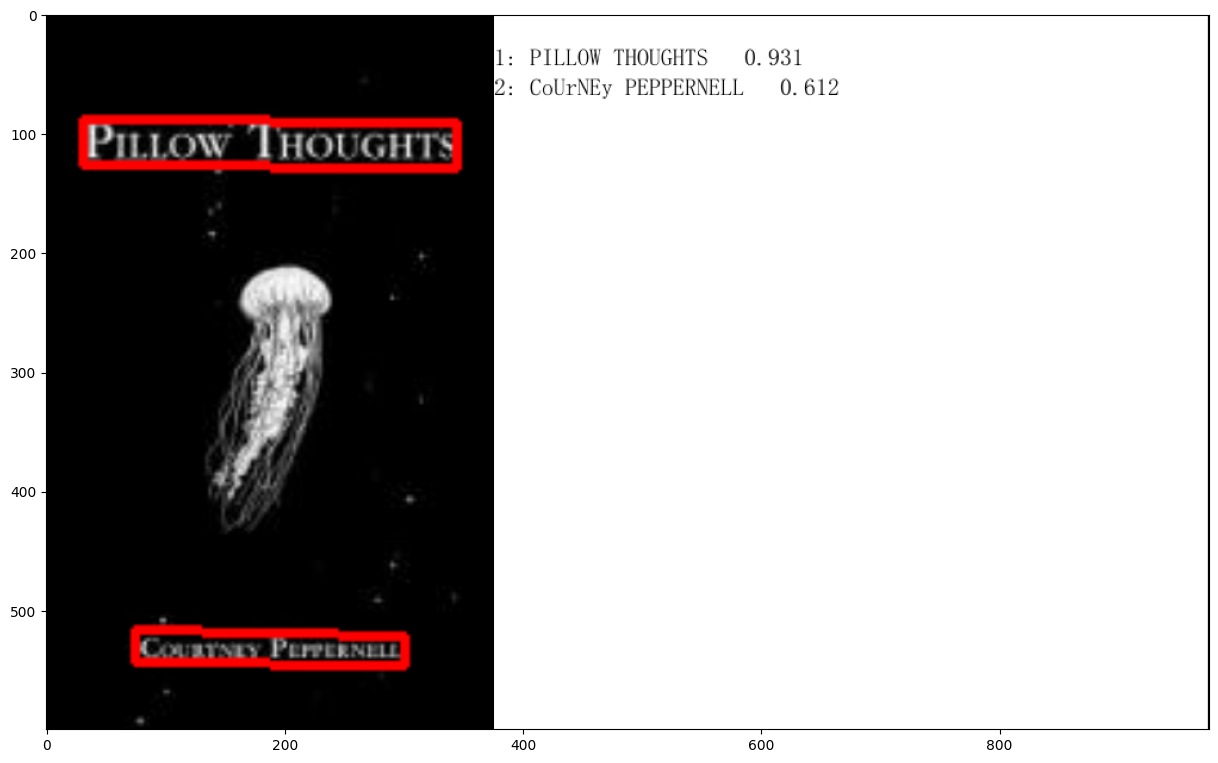

In [42]:
from paddleocr import PaddleOCR, draw_ocr
import cv2
import matplotlib.pyplot as plt
import re
from PIL import Image, ImageDraw, ImageFont

# Set the display size for matplotlib figures.
plt.rcParams['figure.figsize'] = [15, 10]

# Initialize the OCR model.
ocr = PaddleOCR(use_angle_cls=True, lang='en')

# Path to the warped image file.
img_path = '0000049.jpg'
#img_path = 'warped2.png'
image = Image.open(img_path).convert('RGB')
img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)

# Perform OCR on the image.
results = ocr.ocr(img_path, cls=True)[0]

# Drawing results on the image.
boxes = [line[0] for line in results]
txts = [line[1][0] for line in results]
scores = [line[1][1] for line in results]

im_show = draw_ocr(image, boxes, txts, scores, font_path='simfang.ttf')
im_show = Image.fromarray(im_show)
im_show.save('result_book.jpg')
plt.imshow(im_show)
plt.show()


3. NEWSPAPAERS:
----

Idea:
- to extract usefull text from the recepit - title 
- filtering the image by creating a blank image of the same dimensions of the original image and imposing largest contours found in the original image onto the blank image
- use of Paddleocr to find the required text

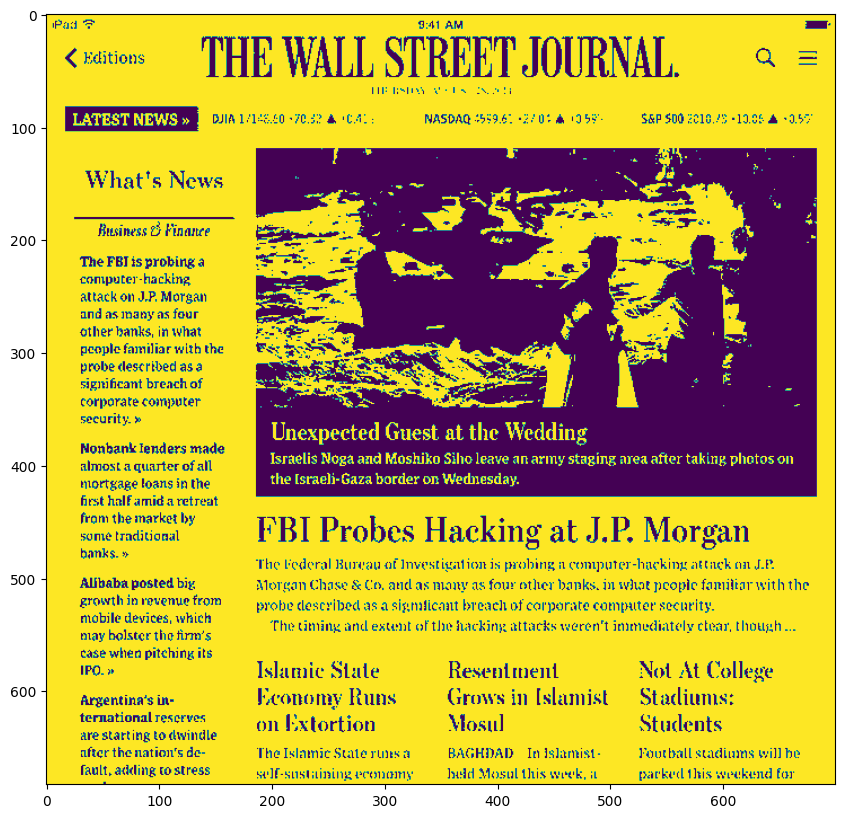

True

In [7]:
import cv2
image = cv2.imread('032.jpg') # reading the image
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # convert2grayscale
(thresh, binary) = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU) # convert2binary
plt.imshow(binary)
plt.show()
cv2.imwrite('binary.png', binary)

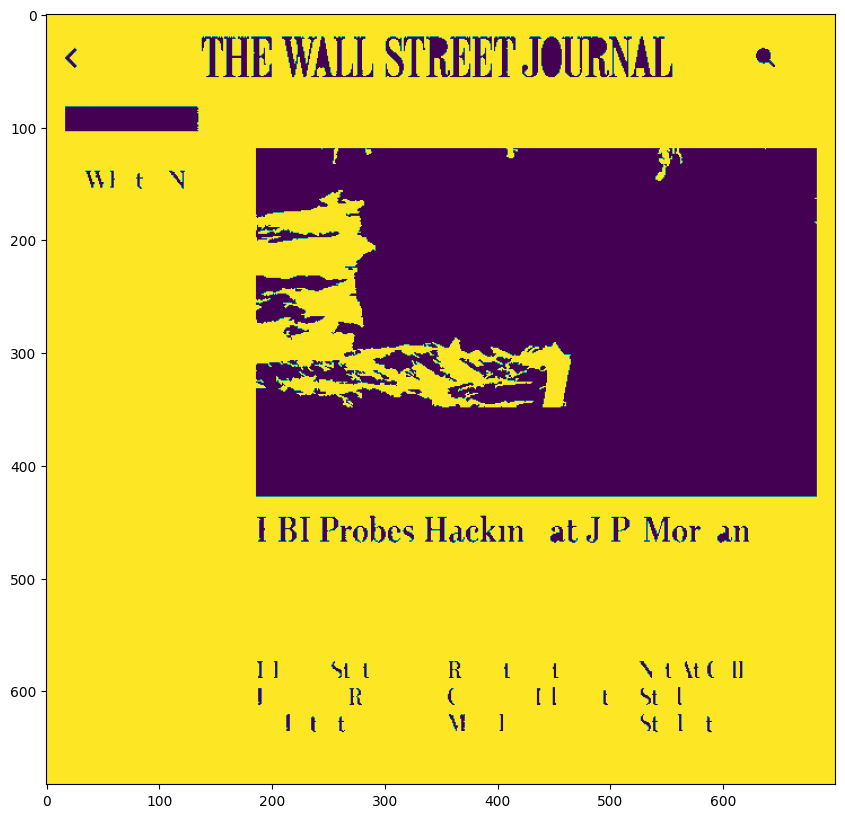

True

In [8]:
import numpy as np
mask = np.ones(image.shape[:2], dtype="uint8") * 255 # create blank image of same dimension of the original image
(contours, _) = cv2.findContours(~binary,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE) 
heights = [cv2.boundingRect(contour)[3] for contour in contours] # collecting heights of each contour
avgheight = sum(heights)/len(heights) # average height
# finding the larger contours
# Applying Height heuristic
for c in contours:
    [x,y,w,h] = cv2.boundingRect(c)
    if h > 2*avgheight:
        cv2.drawContours(mask, [c], -1, 0, -1)
plt.imshow(mask)
plt.show()
cv2.imwrite('filter.png', mask)

[2024/04/24 17:11:31] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/Users/sanjanajd/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/Users/sanjanajd/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25

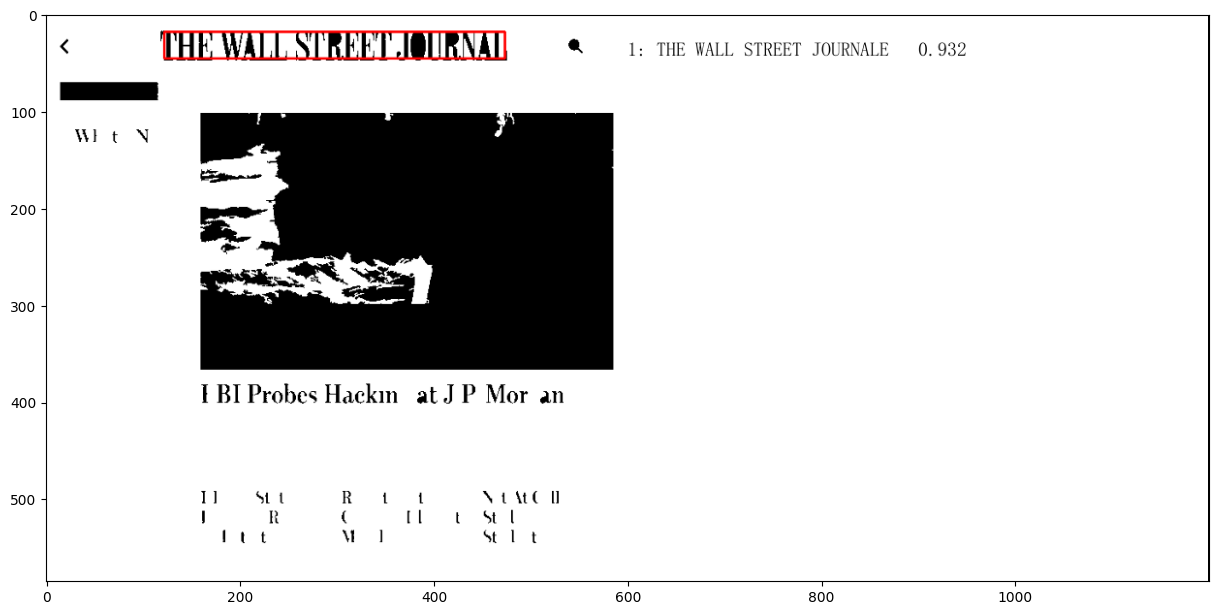

In [9]:
from paddleocr import PaddleOCR, draw_ocr
import cv2
import matplotlib.pyplot as plt
import re
from PIL import Image, ImageDraw, ImageFont

# Set the display size for matplotlib figures.
plt.rcParams['figure.figsize'] = [15, 10]

# Initialize the OCR model.
ocr = PaddleOCR(use_angle_cls=True, lang='en')

# Path to the image file.
img_path = 'filter.png'
#img_path = 'warped2.png'
image = Image.open(img_path).convert('RGB')
img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)

# Perform OCR on the image.
results = ocr.ocr(img_path, cls=True)[0]

# Drawing results on the image.
line = results[0]
boxes = [line[0]]
txts = [line[1][0]]
scores = [line[1][1]]

im_show = draw_ocr(image, boxes, txts, scores, font_path='simfang.ttf')
im_show = Image.fromarray(im_show)
im_show.save('result_news.jpg')
plt.imshow(im_show)
plt.show()
